In [2]:
import sys
sys.path.append("../../../dataset/")
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from train_segformer import train, visualize_example
from transformers import SegformerForSemanticSegmentation
import pandas as pd
import stats
import scienceplots as _


/home/ziereis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path_to_results = 'results/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metrics = [stats.Precision(), stats.Recall(), stats.F2(), stats.Jac(), stats.Acc()]


In [6]:
train_for_cal = TrainDataset('../../../data/', transform=tran.ToTensor())
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
count = len(train_for_cal) * 512 * 512
loader_for_cal = DataLoader(train_for_cal, batch_size=32, shuffle=False)

for inputs, mask in loader_for_cal:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

t_ms = tran.Compose([
        tran.ToTensor(),
        tran.Normalize(total_mean, total_std)
    ])

In [7]:
losses_train = pd.DataFrame({})
losses_test = pd.DataFrame({})
iou_train = pd.DataFrame({})
iou_test = pd.DataFrame({})

In [8]:
def eval_model(pretrain, name, epoch, t):
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/{pretrain}", 
        num_labels=4,
    ).to(device)

    model.load_state_dict(state_dict=torch.load(f'{path_to_results}/{pretrain}_{name}/model_epoch_{epoch}.pth'))
    df = pd.read_csv(f'{path_to_results}/{pretrain}_{name}/training_stats.csv')
    losses_train[f'{pretrain}_{name}'] = df['Train_Loss']
    losses_test[f'{pretrain}_{name}'] = df['Test_Loss']
    iou_train[f'{pretrain}_{name}'] = df['Train_IoU']
    iou_test[f'{pretrain}_{name}'] = df['Test_IoU']

    val = ValDataset('../data/', transform=t, with_background=True)
    val_loader = DataLoader(val, batch_size=1, shuffle=False)
    res = stats.calculate_statistics(model, device, val, val_loader, metrics)
    stats.print_statistics(res, metrics, f'{pretrain}_{name}')
    
t_base = tran.Compose([
        tran.ToTensor(),
    ])

t_05 = tran.Compose([
        tran.ToTensor(),
        tran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

eval_model('mit-b0', 'norm_base', "30",t_base)
eval_model('mit-b0', 'norm_05', "30",t_05)
eval_model('mit-b0', 'norm_ms', "30",t_ms)
eval_model('mit-b1', 'ms_model', "12",t_ms)
eval_model('mit-b2', 'ms_model', "20",t_ms)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b0_norm_base
5
	Precision: 0.7700% | ± 0.2403 (std) | ± 0.0577 (var)
	Recall: 0.4167% | ± 0.2095 (std) | ± 0.0439 (var)
	F2: 0.4431% | ± 0.2068 (std) | ± 0.0428 (var)
	Jac: 0.3646% | ± 0.1856 (std) | ± 0.0345 (var)
	Acc: 0.9722% | ± 0.0346 (std) | ± 0.0012 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b0_norm_05
5
	Precision: 0.7427% | ± 0.2168 (std) | ± 0.0470 (var)
	Recall: 0.4942% | ± 0.2000 (std) | ± 0.0400 (var)
	F2: 0.5148% | ± 0.1985 (std) | ± 0.0394 (var)
	Jac: 0.4163% | ± 0.1772 (std) | ± 0.0314 (var)
	Acc: 0.9749% | ± 0.0266 (std) | ± 0.0007 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b0_norm_ms
5
	Precision: 0.7307% | ± 0.2268 (std) | ± 0.0514 (var)
	Recall: 0.4892% | ± 0.2191 (std) | ± 0.0480 (var)
	F2: 0.5048% | ± 0.2103 (std) | ± 0.0442 (var)
	Jac: 0.4033% | ± 0.1842 (std) | ± 0.0339 (var)
	Acc: 0.9744% | ± 0.0262 (std) | ± 0.0007 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b1_ms_model
5
	Precision: 0.7492% | ± 0.2203 (std) | ± 0.0485 (var)
	Recall: 0.4782% | ± 0.1977 (std) | ± 0.0391 (var)
	F2: 0.4990% | ± 0.1935 (std) | ± 0.0374 (var)
	Jac: 0.4027% | ± 0.1745 (std) | ± 0.0304 (var)
	Acc: 0.9748% | ± 0.0263 (std) | ± 0.0007 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_ms_model
5
	Precision: 0.6792% | ± 0.2276 (std) | ± 0.0518 (var)
	Recall: 0.5899% | ± 0.1942 (std) | ± 0.0377 (var)
	F2: 0.5850% | ± 0.1878 (std) | ± 0.0353 (var)
	Jac: 0.4511% | ± 0.1769 (std) | ± 0.0313 (var)
	Acc: 0.9736% | ± 0.0268 (std) | ± 0.0007 (var)
-----------------------------------


In [13]:
import seaborn as sns
plt.style.use(["science", "nature"])
pallette = sns.color_palette("Set2")

In [36]:
import numpy as np

In [37]:
def prepare_data(data):
    d = [(i + 1, e) for i, e in enumerate(data) if not np.isnan(e)]
    df = pd.DataFrame(d, columns=["epoch", "value"])
    return df

In [46]:
test_losses_hsv = prepare_data(losses_test['mit-b2_aug_flip__HSV_0.0001'].values)
test_losses_flip = prepare_data(losses_test['mit-b2_aug_flip_0.0001'].values)
test_losses_base = prepare_data(losses_test['mit-b2_ms_model'].values)

Text(0, 0.5, 'Loss')

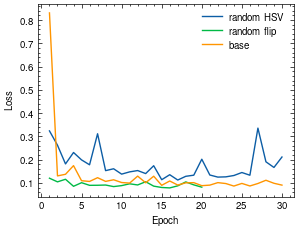

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=1)

sns.lineplot(
    test_losses_hsv, 
    x="epoch", 
    y="value", 
    ax=axs, 
    # linestyle="dashed", 
    label="random HSV", 
    # color=pallette[0],
)


sns.lineplot(
    test_losses_flip , 
    x="epoch", 
    y="value", 
    ax=axs, 
    # linestyle="dashed", 
    label="random flip", 
    # color=pallette[1],
)

sns.lineplot(
    test_losses_base, 
    x="epoch", 
    y="value", 
    ax=axs, 
    # linestyle="dashed", 
    label="base", 
    # color=pallette[1],
)


axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")

In [52]:
fig.savefig("segformer_loss.svg", format="svg")

<Figure size 330x250 with 0 Axes>

In [9]:
eval_model('mit-b2', 'sizes_128', "12", tran.Compose([t_ms, tran.Resize(128)]))
eval_model('mit-b2', 'sizes_256', "20", tran.Compose([t_ms, tran.Resize(256)]))
eval_model('mit-b2', 'lr_0.0001', "12" , t_ms)
eval_model('mit-b2', 'lr_0.00001', '16', t_ms)
eval_model('mit-b2', 'aug_flip_0.0001', "16" , t_ms)
eval_model('mit-b2', 'aug_flip__HSV_0.0001', "24" , t_ms)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_sizes_128
5
	Precision: 0.4103% | ± 0.3803 (std) | ± 0.1446 (var)
	Recall: 0.1668% | ± 0.2209 (std) | ± 0.0488 (var)
	F2: 0.1707% | ± 0.2164 (std) | ± 0.0468 (var)
	Jac: 0.1239% | ± 0.1670 (std) | ± 0.0279 (var)
	Acc: 0.9560% | ± 0.0391 (std) | ± 0.0015 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_sizes_256
5
	Precision: 0.6155% | ± 0.2322 (std) | ± 0.0539 (var)
	Recall: 0.4734% | ± 0.2315 (std) | ± 0.0536 (var)
	F2: 0.4733% | ± 0.2151 (std) | ± 0.0463 (var)
	Jac: 0.3505% | ± 0.1763 (std) | ± 0.0311 (var)
	Acc: 0.9688% | ± 0.0324 (std) | ± 0.0010 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_lr_0.0001
5
	Precision: 0.6686% | ± 0.2155 (std) | ± 0.0464 (var)
	Recall: 0.6366% | ± 0.2087 (std) | ± 0.0436 (var)
	F2: 0.6203% | ± 0.2016 (std) | ± 0.0406 (var)
	Jac: 0.4756% | ± 0.1860 (std) | ± 0.0346 (var)
	Acc: 0.9733% | ± 0.0305 (std) | ± 0.0009 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_lr_0.00001
5
	Precision: 0.7276% | ± 0.2063 (std) | ± 0.0426 (var)
	Recall: 0.5248% | ± 0.2194 (std) | ± 0.0481 (var)
	F2: 0.5371% | ± 0.2123 (std) | ± 0.0451 (var)
	Jac: 0.4273% | ± 0.1851 (std) | ± 0.0342 (var)
	Acc: 0.9740% | ± 0.0281 (std) | ± 0.0008 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_aug_flip_0.0001
5
	Precision: 0.7270% | ± 0.2136 (std) | ± 0.0456 (var)
	Recall: 0.5801% | ± 0.2152 (std) | ± 0.0463 (var)
	F2: 0.5878% | ± 0.2066 (std) | ± 0.0427 (var)
	Jac: 0.4709% | ± 0.1877 (std) | ± 0.0352 (var)
	Acc: 0.9771% | ± 0.0214 (std) | ± 0.0005 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([244, 5])
-----------------------------------
mit-b2_aug_flip__HSV_0.0001
5
	Precision: 0.5552% | ± 0.2501 (std) | ± 0.0626 (var)
	Recall: 0.5661% | ± 0.2513 (std) | ± 0.0631 (var)
	F2: 0.5296% | ± 0.2267 (std) | ± 0.0514 (var)
	Jac: 0.3668% | ± 0.1845 (std) | ± 0.0340 (var)
	Acc: 0.9670% | ± 0.0277 (std) | ± 0.0008 (var)
-----------------------------------
